In [20]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import caffe
import itertools
import pandas
import cv2
import scipy

from math import ceil
from copy import copy
from collections import OrderedDict
from operator import itemgetter, attrgetter
from matplotlib import pyplot
from scipy import ndimage as ndimage

from caffe import layers as L
from caffe import params as P
import tools

from ntb.layer.data import Transformer
from ntb.db import *

%matplotlib inline
pyplot.rcParams['figure.figsize'] = (10, 6)

# set seed to make randomization reproducible
random.seed(0)
np.random.seed(0)

In [21]:
SUB_DIR = "ft_sigmoid_noaug"

In [22]:
db = NTBDB()

# Data preparation

In [23]:
label_to_ntb = {
    'football': ['footbal', 'football-pitches', 'fotballs'],
    'person': ['full-length-portrait', 'portrait', 'persons'],
    'skiing': [
        'skiing', 'alpine-skiing', 'nordic-skiing', 'biathlon', 'freeskiing', 'freestyle-skiing', 'slalom', 'snowboarding', 'giant-slalom',
        'super-g', 'telemark-skiiing', 'downhill-skiing', 'nordic-combined', 'cross-country-skiing', 'ski-jumping', 'ski-orienteering',
        'long-distance-ski-races', 'ski-flying', 'relay-races', 'skis-and-ski-poles', 'ski-trips',
    ],
    'team-handball': ['team-handball'],
    'woman': ['women'],
    'child': ['children', 'girls', 'boys'],
    'skating': ['icehockey', 'skating', 'figure-skating'],
    'flag': ['flags'],
    'crowd': ['demonstrations', 'supporters', 'crowds'],
    'car': ['cars', 'ambulances', 'electric-cars', 'hybrid-cars', 'limousines', 'sports-cars', 'classic-cars', 'police-cars', 'automobile-racing', 'traffic'],
    'bicycling': ['bicycle-racing', 'bicycling', 'road-bicycle-racing', 'bicycles', 'cross-country-bicycling'],
    'flower': ['flowers', 'bouquet-of-flowers'],
    'man': ['men'],
    'medal': ['medals'],
    'snow': ['snow'],
    'hand': ['hands'],
    'triumph': ['sign-of-triumph'],
    'army': ['soldiers', 'the-armed-forces'],
    'boat': ['boats', 'yachting', 'ferries', 'sailboats', 'passenger-ships', 'cruise-ships', 'fishing-boats'],
    'norwegian-national-costumes': ['norwegian-national-costumes'],
    'landscape': ['landscape'],
    'signs': ['signs', 'traffic-signs'],
    'running': ['running-[athletics]', 'middle-distance-running', 'long-distance-running'],
    'aeroplane': ['aeroplanes'],
    'sky': ['sky', 'clouds'],
    'firemen': ['firemen'],
    'beach-volleyball': ['beach-volleyball'],
    'train': ['trains'],
    'umbrella': ['umbrellas'],
    'swimming': ['swimming-[sports]', 'swimming'],
    'dog': ['dogs'],
    'bus': ['buses'],
    'harbour': ['harbours'],
    'park': ['parks', 'forests'],
    'bridge': ['bridges'],
    'tree': ['trees'],
    'shoe': ['shoes'],
    'beach': ['beaches'],
    'helicopter': ['helicopters', 'rescue-helicopters'],
    'red-carpet': ['red-carpet'],
    'horse': ['horses'],
}
labels = np.asarray(sorted(label_to_ntb.keys()))
assert len(list(itertools.chain.from_iterable(label_to_ntb.values()))) == len(set(itertools.chain.from_iterable(label_to_ntb.values()))), "Dublicates"

In [30]:
ntb_to_label = {ntb_label: label for label, ntb_labels in label_to_ntb.items() for ntb_label in ntb_labels}

dataset = {
    label: np.unique(np.asarray(list(itertools.chain.from_iterable(
        map(itemgetter('filename'), db.by_tag[ntb_label]) for ntb_label in ntb_labels
    )))) for label, ntb_labels in label_to_ntb.items()
}

### Labels distribution

In [25]:
def plot_distribution(data):
    pic_num_distribution = {
        label: imgs.size for label, imgs in data.items()
    }
    data = sorted(pic_num_distribution.items(), key=itemgetter(1), reverse=True)
    df = pandas.DataFrame.from_dict(OrderedDict(data), orient='index')
    df.plot(kind='bar', legend=False)

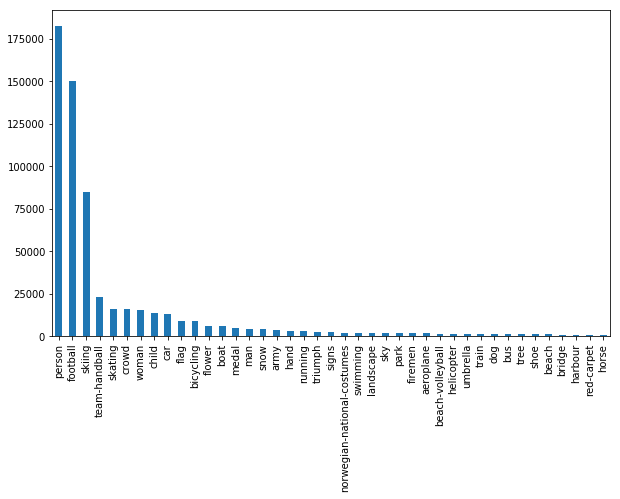

In [7]:
plot_distribution(dataset)

### Reducing imblalance

In [65]:
LIMIT = 10000
dataset_balanced = {label: np.asarray(imgs) for label, imgs in dataset.iteritems()}
for label, imgs in dataset_balanced.iteritems():
    if imgs.size > LIMIT:
        dataset_balanced[label] = np.random.choice(imgs, LIMIT, replace=False)

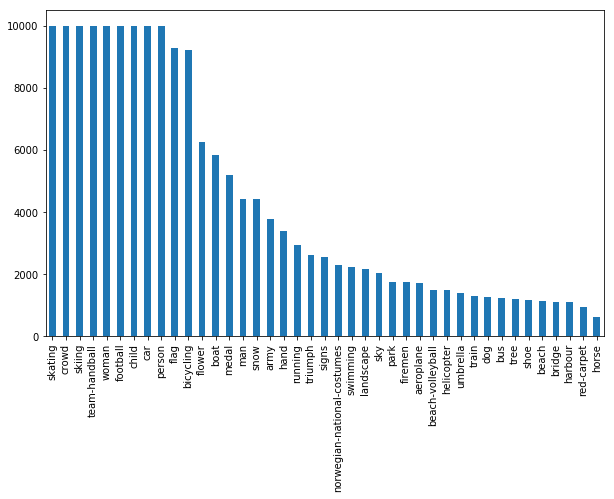

In [66]:
plot_distribution(dataset_balanced)

### Train/Validation/Test dataset split on per category basis

In [67]:
def train_val_test_split(dataset, split=(0.6, 0.2, 0.2)):
    assert sum(split) == 1
    train_ratio, val_ratio, test_ratio = split
    train, val, test = {}, {}, {}
    for label, imgs in dataset.iteritems():
        np.random.shuffle(imgs)
        train[label] = imgs[:int(imgs.size * train_ratio)]
        val[label] = imgs[int(imgs.size * train_ratio):int(imgs.size * (train_ratio + val_ratio))]
        test[label] = imgs[int(imgs.size * (train_ratio + val_ratio)):]
    return train, val, test

In [68]:
train, val, test = train_val_test_split(dataset_balanced)

### Write sampled dataset to sub directory

In [70]:
def dump_training_data(data, split):
    training_data = {}
    for label, imgs in data.iteritems():
        for index in imgs:
            training_data.setdefault(index, {})
            if 'folder' not in training_data[index]:
                training_data[index]['folder'] = db.metadata[index]['folder']
            training_data[index].setdefault('labels', []).append(labels.tolist().index(label))
    data_path = os.path.join(BASE_DIR, 'nets', SUB_DIR, 'data', split + '.pickle')
    with open(data_path, mode='w') as f:
        pickle.dump(training_data, f, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
dump_training_data(train, 'train')
dump_training_data(val, 'val')

In [71]:
with open(os.path.join(BASE_DIR, 'nets', SUB_DIR, 'data', 'test.pickle'), mode='w') as f:
    pickle.dump(test, f, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
with open(os.path.join(BASE_DIR, 'nets', SUB_DIR, 'data', 'labels.np'), mode='w') as f:
    labels.dump(f)

# Training

In [4]:
caffe.set_mode_gpu()

### Define network

In [5]:
def conv_relu(bottom, ks, nout, stride=1, pad=0, group=1):
    conv = L.Convolution(bottom, kernel_size=ks, stride=stride,
                                num_output=nout, pad=pad, group=group)
    return conv, L.ReLU(conv, in_place=True)

def fc_relu(bottom, nout):
    fc = L.InnerProduct(bottom, num_output=nout)
    return fc, L.ReLU(fc, in_place=True)

def max_pool(bottom, ks, stride=1):
    return L.Pooling(bottom, pool=P.Pooling.MAX, kernel_size=ks, stride=stride)

def caffenet_multilabel(data_layer_params):
    # setup the ntb data layer 
    n = caffe.NetSpec()
    n.data, n.label = L.Python(
        module='ntb.layer.data', layer='NTBDataLayer', 
        ntop=2, param_str=str(data_layer_params)
    )

    # caffenet
    n.conv1, n.relu1 = conv_relu(n.data, 11, 96, stride=4)
    n.pool1 = max_pool(n.relu1, 3, stride=2)
    n.norm1 = L.LRN(n.pool1, local_size=5, alpha=1e-4, beta=0.75)
    n.conv2, n.relu2 = conv_relu(n.norm1, 5, 256, pad=2, group=2)
    n.pool2 = max_pool(n.relu2, 3, stride=2)
    n.norm2 = L.LRN(n.pool2, local_size=5, alpha=1e-4, beta=0.75)
    n.conv3, n.relu3 = conv_relu(n.norm2, 3, 384, pad=1)
    n.conv4, n.relu4 = conv_relu(n.relu3, 3, 384, pad=1, group=2)
    n.conv5, n.relu5 = conv_relu(n.relu4, 3, 256, pad=1, group=2)
    n.pool5 = max_pool(n.relu5, 3, stride=2)
    n.fc6, n.relu6 = fc_relu(n.pool5, 4096)
    n.drop6 = L.Dropout(n.relu6, in_place=True)
    n.fc7, n.relu7 = fc_relu(n.drop6, 4096)
    n.drop7 = L.Dropout(n.relu7, in_place=True)
    n.score = L.InnerProduct(n.drop7, num_output=labels.size)
    
    # Changed loss function
    n.loss = L.SigmoidCrossEntropyLoss(n.score, n.label)
    
    return str(n.to_proto())

### Write nets and solver files

In [6]:
workdir = os.path.join('/storage/ntb/nets', SUB_DIR)
if not os.path.isdir(workdir):
    os.makedirs(workdir)
snapshotsdir = os.path.join(workdir, 'snapshots')
if not os.path.isdir(snapshotsdir):
    os.makedirs(snapshotsdir)

solverprototxt = tools.CaffeSolver(
    trainnet_prototxt_path=os.path.join(workdir, "trainnet.prototxt"),
    testnet_prototxt_path=os.path.join(workdir, "valnet.prototxt"),
)
solverprototxt.sp['base_lr'] = "0.0001"
solverprototxt.sp['display'] = "1"
solverprototxt.sp['snapshot'] = "200"
solverprototxt.sp['lr_policy'] = '"fixed"'
solverprototxt.sp['power'] = "0.5"
solverprototxt.sp['snapshot_prefix'] = '"{}"'.format(os.path.join(snapshotsdir, 'snapshot'))
solverprototxt.write(os.path.join(workdir, 'solver.prototxt'))

base_data_layer_params = dict(
    batch_size=124,
    im_shape=[227, 227],
    ntb_root=BASE_DIR,
    sub_dir=SUB_DIR,
    num_labels=labels.size
)
# write train net.
with open(os.path.join(workdir, 'trainnet.prototxt'), 'w') as f:
    data_layer_params = dict(split='train', **base_data_layer_params)
    f.write(caffenet_multilabel(data_layer_params))

# write validation net.
with open(os.path.join(workdir, 'valnet.prototxt'), 'w') as f:
    data_layer_params = dict(split='val', **base_data_layer_params)
    f.write(caffenet_multilabel(data_layer_params))

### Load solver

In [7]:
solver = caffe.SGDSolver(os.path.join(workdir, 'solver.prototxt'))

BatchLoader initialized with 94241 images
NTBDataLayer initialized for sub_dir: ft_sigmoid_noaug, split: train, with bs: 124, im_shape: [227, 227], num_labels: 41.
BatchLoader initialized with 34337 images
NTBDataLayer initialized for sub_dir: ft_sigmoid_noaug, split: val, with bs: 124, im_shape: [227, 227], num_labels: 41.


In [7]:
# Start new training
# solver.net.copy_from('/models/caffenet/bvlc_reference_caffenet.caffemodel')

### Restore from snapshot

In [31]:
for snapshot in sorted(os.listdir(snapshotsdir)):
    if snapshot.endswith('solverstate'):
        print snapshot

snapshot_iter_852.solverstate


In [32]:
solver.restore(os.path.join(snapshotsdir, 'snapshot_iter_853.solverstate'))

In [9]:
solver.test_nets[0].share_with(solver.net)
solver.step(1)

Check images and labels

In [20]:
# transformer = Transformer([227, 227])
# image_index = 2
# pyplot.figure()
# pyplot.imshow(transformer.deprocess(copy(solver.net.blobs['data'].data[image_index, ...])))
# gtlist = solver.net.blobs['label'].data[image_index, ...].astype(np.int)
# pyplot.title('GT: {}'.format(labels[np.where(gtlist)]))
# pyplot.axis('off');

### Train network

In [12]:
# Use hammind distance to check accuracy

def hamming_distance(gt, est):
    return sum([1 for (g, e) in zip(gt, est) if g == e]) / float(len(gt))

def check_accuracy(net, num_batches, batch_size = 128):
    acc = 0.0
    for t in range(num_batches):
        net.forward()
        gts = net.blobs['label'].data
        ests = net.blobs['score'].data > 0
        for gt, est in zip(gts, ests): #for each ground truth and estimated label vector
            acc += hamming_distance(gt, est)
    return acc / (num_batches * batch_size)

In [9]:
def train():
    for itt in range(10):
        solver.step(100)
        print 'itt:{:3d}'.format((itt + 1) * 100), 'accuracy:{0:.4f}'.format(check_accuracy(solver.test_nets[0], 50))

In [ ]:
%time train()

In [29]:
%time solver.step(50)

CPU times: user 1min 2s, sys: 21.1 s, total: 1min 23s
Wall time: 4min 44s


In [ ]:
def check_baseline_accuracy(net, num_batches, batch_size = 128):
    acc = 0.0
    for t in range(num_batches):
        net.forward()
        gts = net.blobs['label'].data
        ests = np.zeros((batch_size, len(gts)))
        for gt, est in zip(gts, ests): #for each ground truth and estimated label vector
            acc += hamming_distance(gt, est)
    return acc / (num_batches * batch_size)

print 'Baseline accuracy:{0:.4f}'.format(check_baseline_accuracy(solver.test_nets[0], 5823/128))

### Look at some prediction results

In [15]:
test_net = solver.test_nets[0]
for image_index in range(100):
    gtlist = test_net.blobs['label'].data[image_index, ...].astype(np.int)
    estlist = test_net.blobs['score'].data[image_index, ...] > 0
    if np.where(estlist)[0].any():
        plt.figure()
        plt.imshow(transformer.deprocess(copy(test_net.blobs['data'].data[image_index, ...])))
        plt.title('GT: {} \n EST: {}'.format(labels[np.where(gtlist)], labels[np.where(estlist)]))
        plt.axis('off')

### Test network

In [14]:
net = caffe.Net(
    os.path.join(workdir, 'testnet.prototxt'),
    os.path.join(workdir, 'snapshots', 'snapshot_iter_852.caffemodel'),
    caffe.TEST
)
transformer = Transformer(shape=[227, 227])

In [15]:
def test_random_image(label):
    index = random.choice(test[label])
    image = caffe.io.load_image(image_path(db.metadata[index]))
    image = scipy.misc.imresize(image, [227, 227])
    
    net.blobs['data'].data[...][0] = transformer.preprocess(image)
    net.forward()
    
    output_prob = net.blobs['score'].data[0]
    top_inds = output_prob.argsort()[::-1][:3]
    top_inds = top_inds[np.where(output_prob[top_inds] > -1)]
    print zip(output_prob[top_inds], labels[top_inds])
    print index
    plt.imshow(image)
    plt.axis('off')

In [16]:
def test_image(image_index, top=3):
    image = caffe.io.load_image(image_path(db.metadata[image_index]))
    image = scipy.misc.imresize(image, [227, 227])
    net.blobs['data'].data[...][0] = transformer.preprocess(image)
    net.forward()
    
    output_score = net.blobs['score'].data[0]
    top_inds = output_score.argsort()[::-1][:top]
    predicted = labels[top_inds]
    groud_truth = np.asarray(list({ntb_to_label[ntb_tag] for ntb_tag in db.metadata[image_index]['tags'] if ntb_tag in ntb_to_label}))
    
    true_positives = np.intersect1d(predicted, groud_truth)
    print predicted, groud_truth, true_positives
    presision = float(true_positives.size) / predicted.size
    recall = float(true_positives.size) / groud_truth.size
    return presision, recall

In [17]:
def get_image_scores(image_index):
    image = caffe.io.load_image(image_path(db.metadata[image_index]))
    image = scipy.misc.imresize(image, [227, 227])
    net.blobs['data'].data[...][0] = transformer.preprocess(image)
    net.forward() 
    return net.blobs['score'].data[0]

In [17]:
# find scores for each image
# for each category, sort images by score, return top N
# Calculate presision/recall rate
# repeat for different N
# plot P/R curve
# Calculate AP

In [ ]:
%time scores = {index: get_image_scores(index) for index in set(itertools.chain.from_iterable(small_test.itervalues()))}

In [18]:
def get_scores(dataset):
    def predict_chunk(chunk):
        for i, index in enumerate(chunk):
            image = caffe.io.load_image(image_path(db.metadata[index]))
            image = scipy.misc.imresize(image, [227, 227])
            net.blobs['data'].data[...][i] = transformer.preprocess(image)
        net.forward()
    def get_chunk_scores(chunk):
        res = []
        for i, index in enumerate(chunk):
            row = list()
            row.insert(0, index)
            yield (index,) + tuple(net.blobs['score'].data[i])
    
    image_indexes = np.unique(np.concatenate(dataset.values()))
    chunks_num = int(ceil(image_indexes.size/256.0))
    scores = []
    print "Going to process", chunks_num, "chunks"
    for i, chunk in enumerate(np.array_split(image_indexes, chunks_num)):
        predict_chunk(chunk)
        scores.extend(get_chunk_scores(chunk))
        if i % 50 == 0:
            print "Chunk", i, "finised"

    dtype = [(label, 'f4') for label in labels]
    dtype.insert(0, ('idx', 'S8'))
    return np.array(scores, dtype=dtype)

In [ ]:
%time scores = get_scores(test)

Going to process 134 chunks
Chunk 0 finised
Chunk 50 finised


In [23]:
_, _, small_test = train_val_test_split(test)

In [27]:
%time scores = get_scores(small_test)

Going to process 56 chunks
Chunk 0 finised
Chunk 50 finised
CPU times: user 1min 14s, sys: 11.1 s, total: 1min 25s
Wall time: 4min 6s


In [30]:
%time scores = get_scores(small_test)

Going to process 28 chunks
Chunk 0 finised
CPU times: user 1min 9s, sys: 15.6 s, total: 1min 24s
Wall time: 3min 42s


In [424]:
#labels[scores[scores['idx'] =='tb16a096'][labels].copy().view('f4').argsort()]

In [19]:
def get_label_curve(scores, label):
    ground_truth_ntb = {im['filename'] for ntb_tag in label_to_ntb[label] for im in db.by_tag[ntb_tag]}
    ground_truth = ground_truth_ntb.intersection(set(scores['idx']))
    sorted_images = np.sort(scores, order=[label], axis=0)[['idx']][::-1].copy().view('S8')
    
    res = []
    predicted_true = 0
    true_positive = 0
    for index in sorted_images:
        predicted_true += 1
        if index in ground_truth:
            true_positive += 1
        p = float(true_positive) / predicted_true
        r = float(true_positive) / len(ground_truth)
        res.append((p, r))
    return np.array(res, dtype=[('presision', 'f4'), ('recall', 'f4')])

In [ ]:
def get_curves(scores):
    curves = {}
    for label in labels:
        curves[label] = get_label_curve(scores, label)
    return curves

In [ ]:
curves = get_curves(scores)

In [ ]:
def get_average_presision(curves):
    recall_range = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    res = {}
    for label, label_curve in curves.iteritems():
        s = 0
        for recall in recall_range:
            s += label_curve[label_curve['recall'] >= recall]['presision'].max()
        res[label] = s / len(recall_range)
    return res

In [ ]:
average_presision = get_average_presision(curves)

### Plot presision/recall curves and Average Presision

In [ ]:
df = pandas.DataFrame.from_records(curves['car']).plot(x='recall', y='presision')

In [193]:
df = pandas.DataFrame.from_records(curves)

In [195]:
# df['car']

In [187]:
df.plot?

In [ ]:
# df = pandas.DataFrame.from_dict(OrderedDict(sorted(average_presision.items(), key=itemgetter(1), reverse=True)), orient='index')
# plot = df.plot(kind='bar', legend=False)

In [29]:
data = {
    'size': [dataset_balanced[label].size for label in labels],
    'ap': [average_presision[label] for label in labels],
}
df = pandas.DataFrame(data, index=list(labels))

In [30]:
df.sort_values('ap', ascending=False)[:10]

,ap,size
football,0.702990,10000
skiing,0.659685,10000
car,0.636990,10000
person,0.589450,10000
skating,0.576019,10000
team-handball,0.558593,10000
bicycling,0.546281,9225
boat,0.519143,5838
landscape,0.496116,2155
flag,0.455366,9289


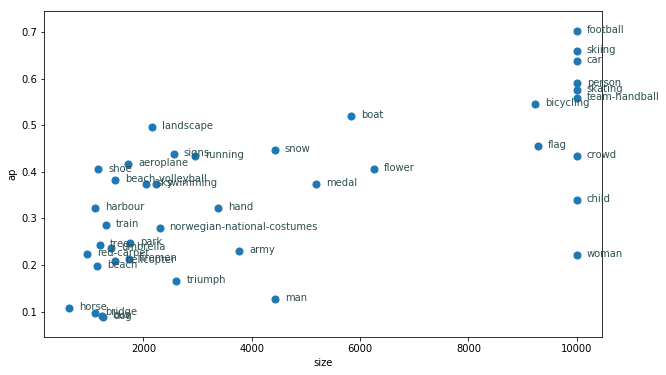

In [31]:
ax = df.plot('size', 'ap', kind='scatter', s=50)
def annotate_df(row):
    ax.annotate(row.name, (row['size'], row['ap']),
                xytext=(10,-2), 
                textcoords='offset points',
                size=10,
                color='darkslategrey')

_ = df.apply(annotate_df, axis=1) # with labels

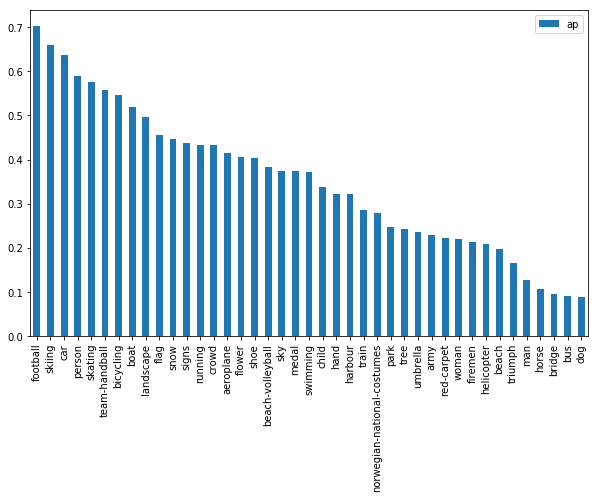

In [177]:
df.sort_values('ap', ascending=False).plot(kind='bar', y='ap')